In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy
from decimal import *
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
import threading
import numpy as np
import datetime

In [3]:
import itertools

In [4]:
number_of_nodes = 10

In [5]:
def calcImportance_pre(stake):

    # get total stake per node
    stakePerNode = [(sum(e)) for e in stake]

    totalStake = sum(stakePerNode)

    n = len(stake)
    weight = [0] * n
    importance = [0] * n
    for x in range(n):
        for y in range(n):
            # weight of a node is 0 if its stake is equal to 0
            #weight(channel) = sqrt(balance(channel) / stake(channel.source) * stake(channel.destination))
            weight[y] += 0 if stakePerNode[y]==0 else numpy.sqrt(stake[y][x]/stakePerNode[y] * stakePerNode[x])

    #print("Weighted downstream stake per node p(n) = ", weight)
    importanceList = numpy.array(weight) * numpy.array(stakePerNode)
    return importanceList;

def setupStake(
        # Number of nodes in the network. This number can be changed to test with small and large network size
        numNodes= number_of_nodes,
        # the minimum number of channels a node can open
        minChannelsPerNode=2,
        # the maximum number of channels a node can open 
        maxChannelsPerNode=10,
        minFundsPerNode=1,
        maxFundsPerNode=1000,
        tokensPerTicket=0.1
    ):

    stake = [[0 for i in range(numNodes)] for j in range(numNodes)]
    listStakePerChannel = []
    avg_stake_list = []
    index_list = []
    for x in range(numNodes-4):
        # each node is given a random funding amount
        myFunds = numpy.random.rand() * (maxFundsPerNode - minFundsPerNode) + minFundsPerNode

        
        # get random number of channels per node
        myChannels = int(numpy.random.rand() * (maxChannelsPerNode - minChannelsPerNode + 1) + minChannelsPerNode)

        # This value represents the amount each node stakes in their channel
        # It is computed as the number of funds a node has divided by number of channels they open
        stakePerChannel = myFunds / myChannels
        stakePerChannel = int(stakePerChannel / tokensPerTicket) * tokensPerTicket
        
        # Creats a list of stakePerChannel
        listStakePerChannel.append(stakePerChannel)

        # Identifying the maximum stake
        maxListStakePerChannel = max(listStakePerChannel)
        
        # Identifying the "position" of the stake - which node initiated 
        index = listStakePerChannel.index(maxListStakePerChannel)
        index_list.append(index)
        index_max = max(index_list)

        # fund channels by writing into stake matrix
        for c in range(myChannels):
            # TODO: this does not prevent a node from opening a channel to the same counterparty multiple times
            counterparty = int(numpy.random.rand() * (numNodes - 5))

            # cannot open channel to self - keep diagonal of matrix at 0
            if counterparty >= x:
                counterparty = counterparty + 1
            stake[x][counterparty] = stakePerChannel
        
        sum_stake = sum([sum(stake[li]) for li in range(numNodes-4)])
        avg_stake = sum_stake/(numNodes-4)
        
    importance_score = calcImportance_pre(stake)
    
    
    #calculating imporance score
    importance_max = max(importance_score)
    index_of_importance = numpy.where(importance_score == importance_max)
    importance_max_i = index_of_importance[0][0]
    
    strategy_fund = numpy.random.rand() * (maxFundsPerNode - minFundsPerNode) + minFundsPerNode       
 
    #non_random node 3, strategy: placing all the stake on the node, which has the highest importance score
    stake[numNodes-4][importance_max_i] = strategy_fund
    
    #non_random node 1, strategy: spreading the stakes equally between the channels
    for b in range(numNodes-4):
        stake[numNodes-3][b] = strategy_fund/(numNodes-4)
        
    #non_random node 2, strategy: spreading the stakes between the channels based on their proportionate share of the sum of stakes
    for r in range(numNodes-4):
        stake[numNodes-2][r] = sum(stake[r])/sum_stake*strategy_fund
    
    stake = [[Decimal(i) for i in j] for j in stake]
    
    return stake

In [6]:
def calcImportance(stake):

    # get total stake per node
    stakePerNode = [Decimal(sum(e)) for e in stake]

    totalStake = sum(stakePerNode)

    n = len(stake)
    weight = [0] * n
    importance = [0] * n
    for x in range(n):
        for y in range(n):
            # weight of a node is 0 if its stake is equal to 0
            #weight(channel) = sqrt(balance(channel) / stake(channel.source) * stake(channel.destination))
            weight[y] += 0 if stakePerNode[y]==0 else numpy.sqrt(stake[y][x]/stakePerNode[y] * stakePerNode[x])

    #print("Weighted downstream stake per node p(n) = ", weight)
    importanceList = numpy.array(weight) * numpy.array(stakePerNode)
    return importanceList;

In [7]:
def selectChannel(weights, weightIndexToNodeLUT):
    """
    Randomly selects a counterparty based on weights according to a LUT
    Returns the node id (or -1 if none could be found)
    Parameters
    ----------
    weights: a list of weights to be used for normalizing the random selection
    weightIndexToNodeLUT: a LUT translating the weights list to node ids
    """
    rand = numpy.random.rand()
    totalWeight = sum(weights)
    sumWeights = 0
    counterparty = -1
    for i in enumerate(weights):
        sumWeights += i[1]
        if totalWeight == 0:
           sumWeights = 0
        else:
            if sumWeights / totalWeight >= rand:
               counterparty = weightIndexToNodeLUT[i[0]]
               break;
    return counterparty

In [8]:
def randomPickWeightedByImportance(importance):
    channel = selectChannel(importance, [i for i in range(len(importance))])
    return channel

In [9]:
def openChannels(stake, importance):
        #print("opening channels")
        numOpenChannels = 0
        channelcount = 1
        ctn = number_of_nodes-1
        openchannelid = [ctn]
        tokensPerChannel = 10
        # add own id to avoid self-staking
        while (numOpenChannels < channelcount):

            # do not open channels to same counterparty multiple times
            tmpImportance = list(importance)
            for i in range(len(importance)):
                if i in openchannelid:
                    tmpImportance[i] = 0

            newChannel = randomPickWeightedByImportance(tmpImportance)
            
            if (newChannel == -1):
                print("ERROR: could not find a counterparty to open the channel to!")
                # TODO: here we should try again but this time including 0 importance nodes
            else:
                #print("opening channel to node ", newChannel)
                stake[ctn][newChannel] = stake[ctn][newChannel] + 10
                openchannelid.append(newChannel)
            # if opening channels didn't work we still want this loop to terminate
            numOpenChannels = numOpenChannels + 1
        
        return openchannelid

In [10]:
 def sendPacket(stake, importance):
        #print("sending packet")

        # persist importance list between attempts so that dead ends can be removed
        importanceAttempts = importance.copy()
        attemptsPerTick = 10
        hops = 3
        numPlayers = 4
        ctNodeId = number_of_nodes-1

        for a in range(attemptsPerTick):
            nextNodeIndex = ctNodeId
            pathIndices = [nextNodeIndex]

            # try to find a path
            for j in range(hops):
                # reset importance
                importanceTmp = importanceAttempts.copy()
                #hoprsim.printArray1d(importanceTmp, 1)

                # remove importance entries for nodes to which current hop has no open channels
                # this is used in the path selection for the next hop
                for i in range(numPlayers):
                    if stake[nextNodeIndex][i] == 0 :
                        importanceTmp[i] = 0

                # prevent loops in path by removing existing nodes on path from list
                for i in pathIndices:
                    importanceTmp[i] = 0

                #hoprsim.printArray1d(importanceTmp, 1)
                nextNodeIndex = randomPickWeightedByImportance(importanceTmp)
                if nextNodeIndex == -1:
                    break # stop looking for path if no next node could be found
                pathIndices.append(nextNodeIndex)

            #print("Found path: ", pathIndices)
            if len(pathIndices) < hops + 1:
                print('ignored path')
            else:
                return pathIndices
            # then facilitate they payout to each node
            # but only as long as the edge is valid (new earnings + existing earnings <= counter party stake)

In [11]:
def iteration_with_fixed_stake(stake, importance):    
    opening_count = []
    opening_list = []
    sending_count = []
    sending_list = []
    
    for _ in range(1000):
        #running the openChannel function 1000 times 
        #creating a list from the outputs
        opening_channel_to = openChannels(stake, importance)
        opening_count.append(opening_channel_to)
        sending_packet_to = sendPacket(stake, importance)
        sending_count.append(sending_packet_to)
    
    #orginizing the list in a dataframe - where each opening/sending position refers to a column 
    opening_pd = pd.DataFrame(opening_count)
    sending_pd = pd.DataFrame(sending_count)

    #summing up the opening appearance by node
    for h in range(len(opening_pd.columns)):
        #counting the value by opening positions (e.g. - how many times showep up the given node as the first node of openings)
        openings = opening_pd[h].value_counts()
        opening_list.append(openings)
    #organizing the list in a new dataframe
    opening_list = pd.concat(opening_list).to_frame().reset_index()
    opening_list.columns = ['node_opening_to', 'sum_opening']
      
      #summing up the sending appearance by node
    for k in range(len(sending_pd.columns)):
        #counting the value by opening positions (e.g. - how many times showep up the given node as the first node of openings)
        sendings = sending_pd[k].value_counts()
        sending_list.append(sendings)
    #organizing the list in a new dataframe
    sending_list = pd.concat(sending_list).to_frame().reset_index()
    sending_list.columns = ['node_sending_to', 'sum_sending']
    
    
    #summing up by nodes
    opening_list = opening_list.groupby(['node_opening_to']).sum()
    sending_list = sending_list.groupby(['node_sending_to']).sum()
    stake_ct = stake[number_of_nodes-1]
    
    output = pd.concat([opening_list, sending_list], axis=1)
    output['stake'] = stake_ct
    
    return output

In [12]:
iteration_list = []
total_stake_pernode = []

def iteration_with_random_setup():
    for _ in range(100):
        # creating a new stake matrix and calculating it's importance
        ini_stake = setupStake()
        ini_importance = calcImportance(ini_stake)
        #calculating the sum of stakes per node 
        for p in range(len(ini_stake)):
            j = sum(ini_stake[p])
            total_stake_pernode.append(j)
            total_stake_pernode_df = pd.DataFrame(total_stake_pernode)
        #running the "number of openings" function
        output = iteration_with_fixed_stake(ini_stake, ini_importance)
        #creating a list from the iterations
        iteration_list.append(output)
        iteration_list_df = pd.concat(iteration_list)
        iteration_list_df = iteration_list_df.reset_index(drop=False)
    
    #merging the sum of the stakes and the ineration dataframe 
    iteration_output = pd.concat([iteration_list_df, total_stake_pernode_df], axis=1)
    iteration_output = iteration_output.rename(columns={'index': 'node_number', 0: 'total_stake_per_node'})
    return iteration_output


In [13]:
iteration_random = iteration_with_random_setup()
iteration_random

,node_number,sum_opening,sum_sending,stake,total_stake_per_node
0,0,104.0,378.0,1040,407.2000000000000454747350888
1,1,1.0,6.0,10,6
2,2,102.0,271.0,1020,284.0000000000000213162820729
3,3,66.0,175.0,660,188.7000000000000170530256583
4,4,29.0,111.0,290,173.1000000000000085265128291
...,...,...,...,...,...
995,5,2.0,7.0,20,4.500000000000000111022302464
996,6,208.0,644.0,2080,945.4400575994776545485365205
997,7,287.0,795.0,2870,945.4400575994775977051176596
998,8,314.0,813.0,3140,945.4400575994776154686860537


In [14]:
#removing the CT node
df = iteration_random[iteration_random["node_number"] != number_of_nodes-1]
df

,node_number,sum_opening,sum_sending,stake,total_stake_per_node
0,0,104.0,378.0,1040,407.2000000000000454747350888
1,1,1.0,6.0,10,6
2,2,102.0,271.0,1020,284.0000000000000213162820729
3,3,66.0,175.0,660,188.7000000000000170530256583
4,4,29.0,111.0,290,173.1000000000000085265128291
...,...,...,...,...,...
994,4,16.0,72.0,160,68
995,5,2.0,7.0,20,4.500000000000000111022302464
996,6,208.0,644.0,2080,945.4400575994776545485365205
997,7,287.0,795.0,2870,945.4400575994775977051176596


In [15]:
conditions = [
    (df['node_number'] == number_of_nodes-2),
    (df['node_number'] == number_of_nodes-3),
    (df['node_number'] == number_of_nodes-4),
    (df['node_number'] < number_of_nodes-4)
    ]

values = ['weighted', 'equal_spread', 'all_in', 'random']

df['node_runners'] = np.select(conditions, values)

df.head()

C:\Users\szany\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,node_number,sum_opening,sum_sending,stake,total_stake_per_node,node_runners
0,0,104.0,378.0,1040,407.2000000000000454747350888,random
1,1,1.0,6.0,10,6,random
2,2,102.0,271.0,1020,284.0000000000000213162820729,random
3,3,66.0,175.0,660,188.7000000000000170530256583,random
4,4,29.0,111.0,290,173.1000000000000085265128291,random


In [17]:
df["total_stake_per_node_m"] = df["total_stake_per_node"].apply(lambda x: float(x))
df["sum_sending_m"] = df["sum_sending"].apply(lambda x: float(x))

C:\Users\szany\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\szany\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


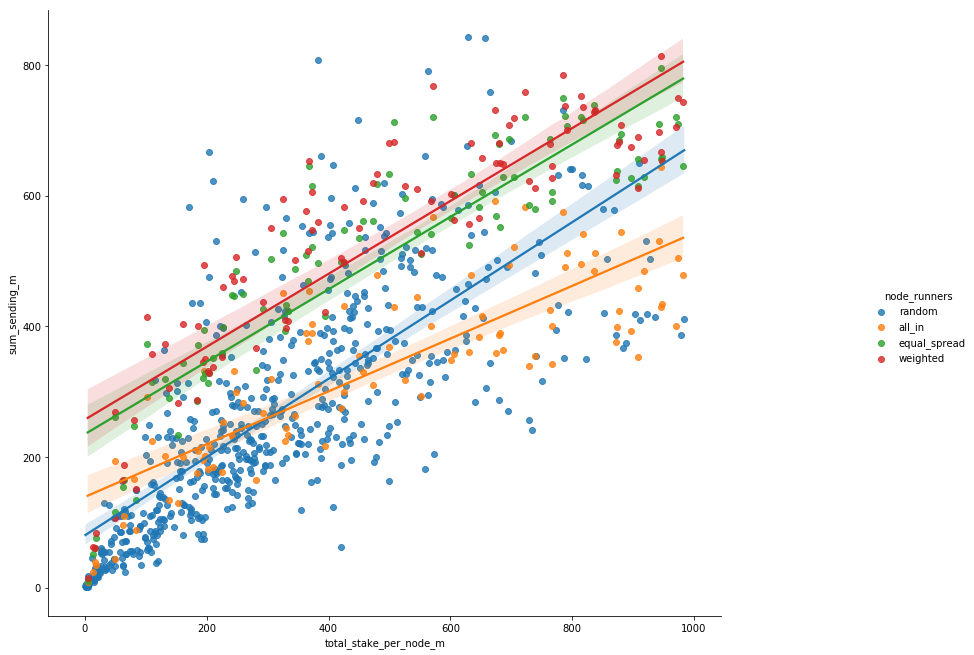

In [18]:
sns.lmplot(x="total_stake_per_node_m", y="sum_sending_m", hue="node_runners", data=df)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

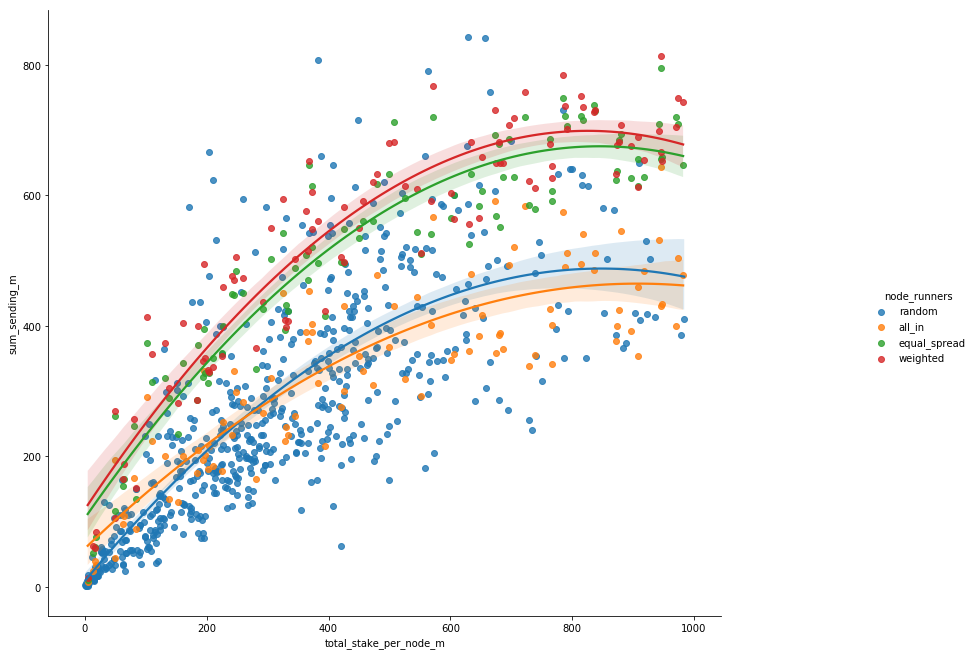

In [24]:
sns.lmplot(x="total_stake_per_node_m", y="sum_sending_m", hue="node_runners", data=df, order=2)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

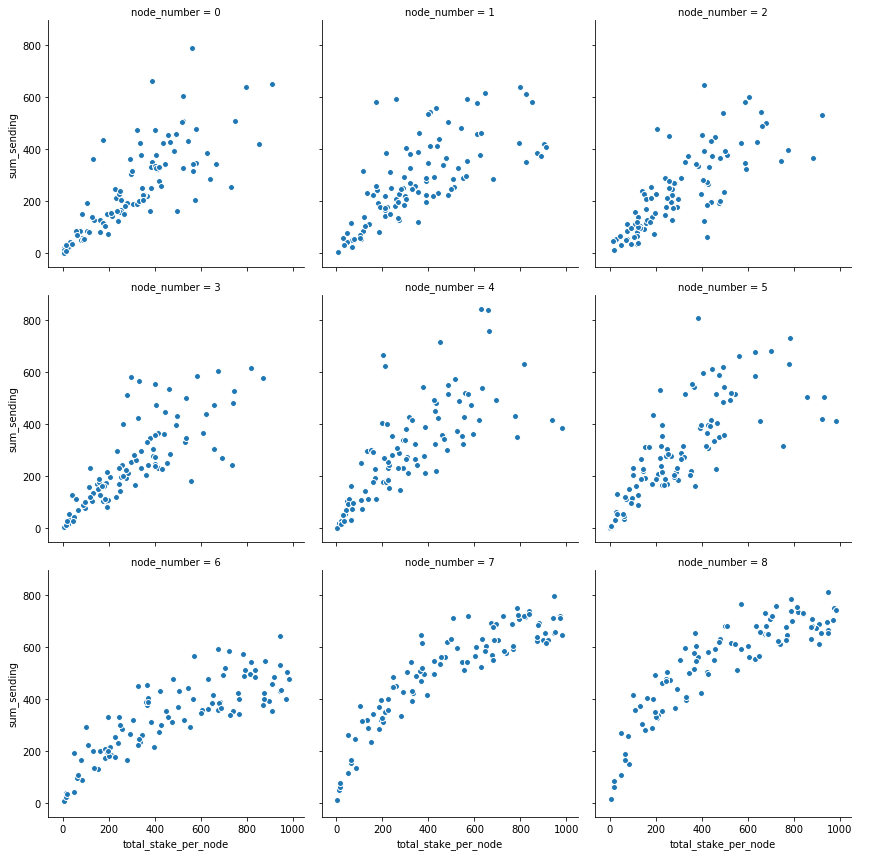

In [21]:
g = sns.FacetGrid(df, col="node_number", height=4, col_wrap=3)
g = (g.map(plt.scatter, "total_stake_per_node", "sum_sending", edgecolor="w").add_legend())